In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

import scipy.stats

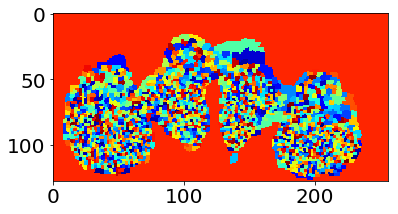

In [34]:
z=42
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

#load clusters
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
#labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file) #z,t

colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = np.random.randint(0,1000,1)
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T,cmap='jet')

# Correct for num of clusters based on amount of brain in slice

In [17]:
### Correct for less brain in edge slices
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
brains = []
for fly in fly_names:
    print(fly)
    brain_file = os.path.join(dataset_path, fly, 'func_0', 'brain_zscored_green_high_pass_masked_warped.nii')
    #brains.append(np.array(nib.load(brain_file).get_data(), copy=True))
    brains.append(np.array(nib.load(brain_file).dataobj[..., 1000]))

brains = np.asarray(brains)
brains.shape

fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [82]:
all_depths = []
for j in range(9):
    depths = []
    for i in range(49):
        depths.append(np.sum(np.where(brains[j,:,:,i]>0)))
    all_depths.append(depths)
all_depths = np.asarray(all_depths)
depth_correction = np.mean(all_depths,axis=0)

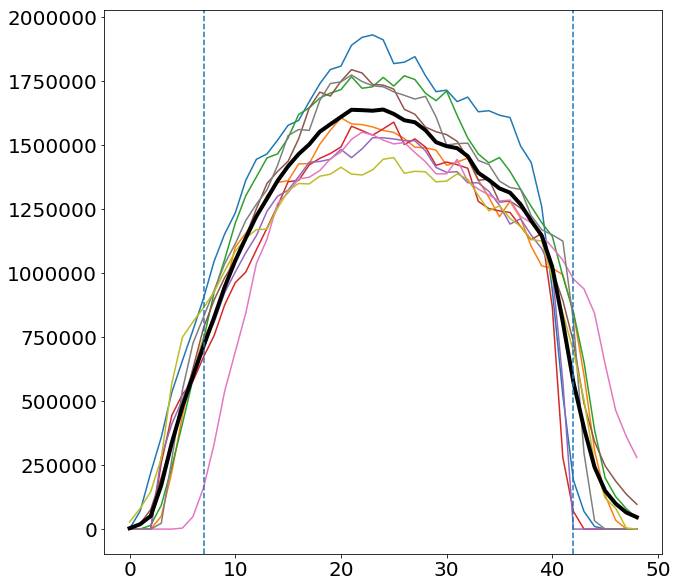

In [83]:
plt.figure(figsize=(10,10))
for j in range(9):
    plt.plot(all_depths[j,:])
plt.plot(depth_correction,color='k',linewidth=4)
plt.axvline(7,linestyle='--')
plt.axvline(42,linestyle='--')

In [84]:
depth_correction=depth_correction/np.max(depth_correction)

In [86]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/depth_correction"
np.save(file, depth_correction)

In [88]:
import pickle

file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/depth_correction.pickle"

with open(file, 'wb') as handle:
    pickle.dump(depth_correction, handle, protocol=pickle.HIGHEST_PROTOCOL)

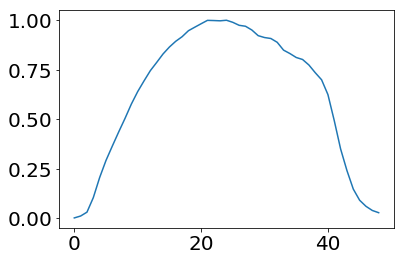

In [85]:
plt.plot(depth_correction)

In [5]:
fly_idx_delete = 3 #(fly_095)

In [ ]:
## Only needed to run once to create and save the labels

def create_clusters(brain, n_clusters):
    t0 = time.time()
    clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices"
    super_to_cluster = brain.reshape(-1, 3384*9)
    connectivity = grid_to_graph(256,128)
    cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    cluster_model.fit(super_to_cluster)
    print('Duration: {}'.format(time.time()-t0))
    return cluster_model

labels = []
for z in range(49):
    print(z)
    t0 = time.time()
    brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z)
    brain = np.array(nib.load(brain_file).get_data(), copy=True)
    print(f'Duration: {time.time()-t0}')
    brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

    n_clusters = 2000
    cluster_model = create_clusters(brain, n_clusters)
    labels.append(cluster_model.labels_)
    
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000'
np.save(save_file, np.asarray(labels))

0
Duration: 24.86052441596985
Duration: 100.40000486373901
1
Duration: 13.25198483467102
Duration: 112.3148922920227
2
Duration: 10.05938720703125
Duration: 130.98712420463562
3
Duration: 19.190443515777588
Duration: 138.90521359443665
4
Duration: 13.793853998184204
Duration: 131.33219027519226
5
Duration: 11.416952133178711
Duration: 131.61648988723755
6
Duration: 15.835224628448486
Duration: 123.88473105430603
7
Duration: 15.198737621307373
Duration: 128.89699912071228
8
Duration: 15.982274532318115
Duration: 124.9356324672699
9
Duration: 13.573019742965698
Duration: 123.57854580879211
10
Duration: 12.971484422683716
Duration: 124.288902759552
11
Duration: 18.592094898223877
